In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
import pickle
file_x = open('./ofm_dataset_x.pkl', 'rb')
file_y = open('./ofm_dataset_y.pkl', 'rb')
X = pickle.load(file_x, encoding='bytes')

# print size of dataset
print('Dataset-Size: {}'.format(X.shape[0]))

# find max and min element in X
minMat = np.min(X)
maxMat = np.max(X)
print("Min Element: {}\nMax Element: {}".format(minMat, maxMat))

Y = pickle.load(file_y, encoding='bytes')
# X = np.stack((X,)*3, axis=-1)

Dataset-Size: 1005
Min Element: 0.0
Max Element: 2.5780038377488013


In [6]:
dataset_size = X.shape[0]
train_size = int((dataset_size*90)/100)
X_train = X[:train_size]
Y_train = Y[:train_size]
idx = np.random.permutation(X_train.shape[0])
X_train = X_train[idx]
Y_train = Y_train[idx]

### set Y to 0 for testing 
Y_train = Y_train*0

X_test = X[train_size:]
Y_test = Y[train_size:]

In [7]:
# Hyperparams
BATCH_SIZE = 4
LR = 0.003 # initial Learning Rate

In [8]:
from torch.utils.data import Dataset, TensorDataset
import torchvision
import torchvision.transforms as transforms

class FingerprintDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
    
    def __getitem__(self, index):
        x = self.samples[0][index]
        y = self.samples[1][index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, torch.tensor(y)
    
    def __len__(self):
        return self.samples[0].shape[0]

In [9]:
transform = transforms.Compose([
     transforms.ToTensor()])

train_dataset = FingerprintDataset((X_train, Y_train), transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_dataset = FingerprintDataset((X_test, Y_test), transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img, label, predicted=False):
    npimg = np.uint8((img.numpy()*255.0)/maxMat)
    npimg = np.transpose(npimg, (1, 2, 0))
    img = np.reshape(npimg, (npimg.shape[0], npimg.shape[1]))
    if predicted==False:    
        plt.title("Formation-Energy: {}".format(label))
    else:
        plt.title("Formation-Energy\n   Ground-truth: {}\n   Predicted: {}".format(label, predicted))
    plt.axis('off')
    plt.imshow(img)
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)

# show first 2 images from the batch
for i in range(2):
    imshow(images[i], labels[i])

torch.Size([4, 1, 32, 32])


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [3]:
from model import Net

In [4]:
net = Net()
net = net.float()
net.to(device)

Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=7744, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [13]:
import torch.optim as optim

# criterion = nn.L1Loss()
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
# optimizer = optim.Adam(net.parameters(), lr=LR)
optimizer = optim.RMSprop(net.parameters(), lr=LR)

In [14]:
def adjust_learning_rate(optimizer, k):
#     """Sets the learning rate to the initial LR decayed by 10 every k epochs"""
    assert type(k) is int
#     lr = LR * (0.1 ** (epoch // k))
    lr = LR // k
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [15]:
# def train(trainloader, numEpochs, k):
    
#     for epoch in range(numEpochs):  # loop over the dataset multiple times
#         running_loss = 0.0
#         if epoch != 0 and epoch%k==0: adjust_learning_rate(optimizer, epoch, k)
#         for i, data in enumerate(trainloader, 0):
#             # get the inputs; data is a list of [inputs, labels]
#             inputs, labels = data[0].float().to(device), data[1].float().to(device)
#             labels = labels.squeeze_()
#             # zero the parameter gradients
#             optimizer.zero_grad()
            
#             # print(inputs.shape)
#             # forward + backward + optimize
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             # print statistics
#             running_loss += loss.item()
#             if i % 10 == 9:    # print every 10 mini-batches
#                 print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss / 10))
#                 running_loss = 0.0

#     print('Finished Training')

In [16]:
def train(trainloader, numEpochs, k):
    
    for epoch in range(numEpochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].float().to(device), data[1].float().to(device)
            labels = labels.squeeze_()
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # print(inputs.shape)
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('Epoch [%d] loss: %.3f' % (epoch + 1, running_loss / len(X_train)))
        running_loss = 0.0

    print('Finished Training')

In [17]:
"""Sets the learning rate to the initial LR decayed by 10 every k epochs"""
k = 1
train(train_loader, 50, 10)

/home/nikhil.bansal/anaconda3/envs/mlns/lib/python3.7/site-packages/torch/nn/modules/loss.py:782: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


Epoch [1] loss: 0.075
Epoch [2] loss: 0.000
Epoch [3] loss: 0.000
Epoch [4] loss: 0.000
Epoch [5] loss: 0.000
Epoch [6] loss: 0.000
Epoch [7] loss: 0.000
Epoch [8] loss: 0.000
Epoch [9] loss: 0.000
Epoch [10] loss: 0.000
Epoch [11] loss: 0.000
Epoch [12] loss: 0.000
Epoch [13] loss: 0.000
Epoch [14] loss: 0.000
Epoch [15] loss: 0.000
Epoch [16] loss: 0.000
Epoch [17] loss: 0.000
Epoch [18] loss: 0.000
Epoch [19] loss: 0.000
Epoch [20] loss: 0.000
Epoch [21] loss: 0.000
Epoch [22] loss: 0.000
Epoch [23] loss: 0.000
Epoch [24] loss: 0.000
Epoch [25] loss: 0.000
Epoch [26] loss: 0.000
Epoch [27] loss: 0.000
Epoch [28] loss: 0.000
Epoch [29] loss: 0.000
Epoch [30] loss: 0.000
Epoch [31] loss: 0.000
Epoch [32] loss: 0.000
Epoch [33] loss: 0.000
Epoch [34] loss: 0.000
Epoch [35] loss: 0.000
Epoch [36] loss: 0.000
Epoch [37] loss: 0.000
Epoch [38] loss: 0.000
Epoch [39] loss: 0.000
Epoch [40] loss: 0.000
Epoch [41] loss: 0.000
Epoch [42] loss: 0.000
Epoch [43] loss: 0.000
Epoch [44] loss: 0.0

In [18]:
adjust_learning_rate(optimizer, 3)

In [19]:
"""Sets the learning rate to the initial LR decayed by 10 every k epochs"""
k = 1
train(train_loader, 50, 10)

Epoch [1] loss: 0.000
Epoch [2] loss: 0.000
Epoch [3] loss: 0.000
Epoch [4] loss: 0.000
Epoch [5] loss: 0.000
Epoch [6] loss: 0.000
Epoch [7] loss: 0.000
Epoch [8] loss: 0.000
Epoch [9] loss: 0.000
Epoch [10] loss: 0.000
Epoch [11] loss: 0.000
Epoch [12] loss: 0.000
Epoch [13] loss: 0.000
Epoch [14] loss: 0.000
Epoch [15] loss: 0.000
Epoch [16] loss: 0.000
Epoch [17] loss: 0.000
Epoch [18] loss: 0.000
Epoch [19] loss: 0.000
Epoch [20] loss: 0.000
Epoch [21] loss: 0.000
Epoch [22] loss: 0.000
Epoch [23] loss: 0.000
Epoch [24] loss: 0.000
Epoch [25] loss: 0.000
Epoch [26] loss: 0.000
Epoch [27] loss: 0.000
Epoch [28] loss: 0.000
Epoch [29] loss: 0.000
Epoch [30] loss: 0.000
Epoch [31] loss: 0.000
Epoch [32] loss: 0.000
Epoch [33] loss: 0.000
Epoch [34] loss: 0.000
Epoch [35] loss: 0.000
Epoch [36] loss: 0.000
Epoch [37] loss: 0.000
Epoch [38] loss: 0.000
Epoch [39] loss: 0.000
Epoch [40] loss: 0.000
Epoch [41] loss: 0.000
Epoch [42] loss: 0.000
Epoch [43] loss: 0.000
Epoch [44] loss: 0.0

In [6]:
PATH = '../trained_nets/propertyPredictionUsingOFM_net.pth'
torch.save(net.state_dict(), PATH)

In [22]:
Y_test = 0

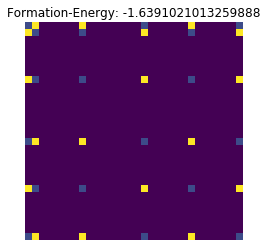

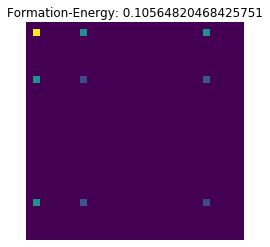

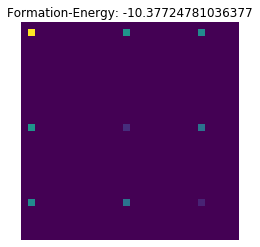

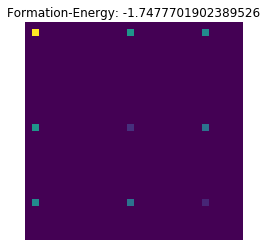

In [23]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
for i in range(BATCH_SIZE):
    imshow(images[i], labels[i])

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [26]:
outputs = net(images.float())

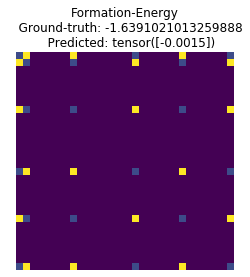

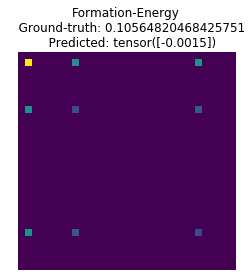

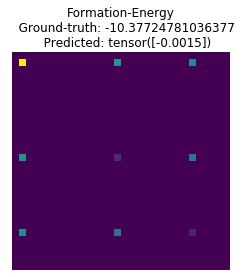

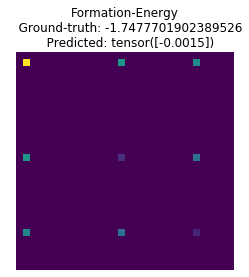

In [27]:
predicted = outputs.data

for i in range(BATCH_SIZE):
    imshow(images[i], labels[i], predicted[i])

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images.float())
        predicted = outputs.data
        total += labels.size(0)
        for i in range (labels.size(0)):
            if np.abs(predicted[i].item() - labels[i].item()) < 0.01:
                correct += 1

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100*correct/total))